https://machinelearningmastery.com/xgboost-for-time-series-forecasting/?__cf_chl_tk=Ys_GJWx4Z.qSLLyF84OVv7O5HwEHC77TOzgb_9zsuPo-1742236350-1.0.1.1-eH9oFZyZ8iX0lWeKJfn_cKnIxxWQhnQMuQ7jYe5wTxU

In [2]:
import os
import re
import unicodedata
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import textstat
from textblob import TextBlob
from textblob_nl import PatternAnalyzer
from tqdm.notebook import tqdm
import requests
from sklearn.metrics import mean_absolute_error


nu al train split maken 

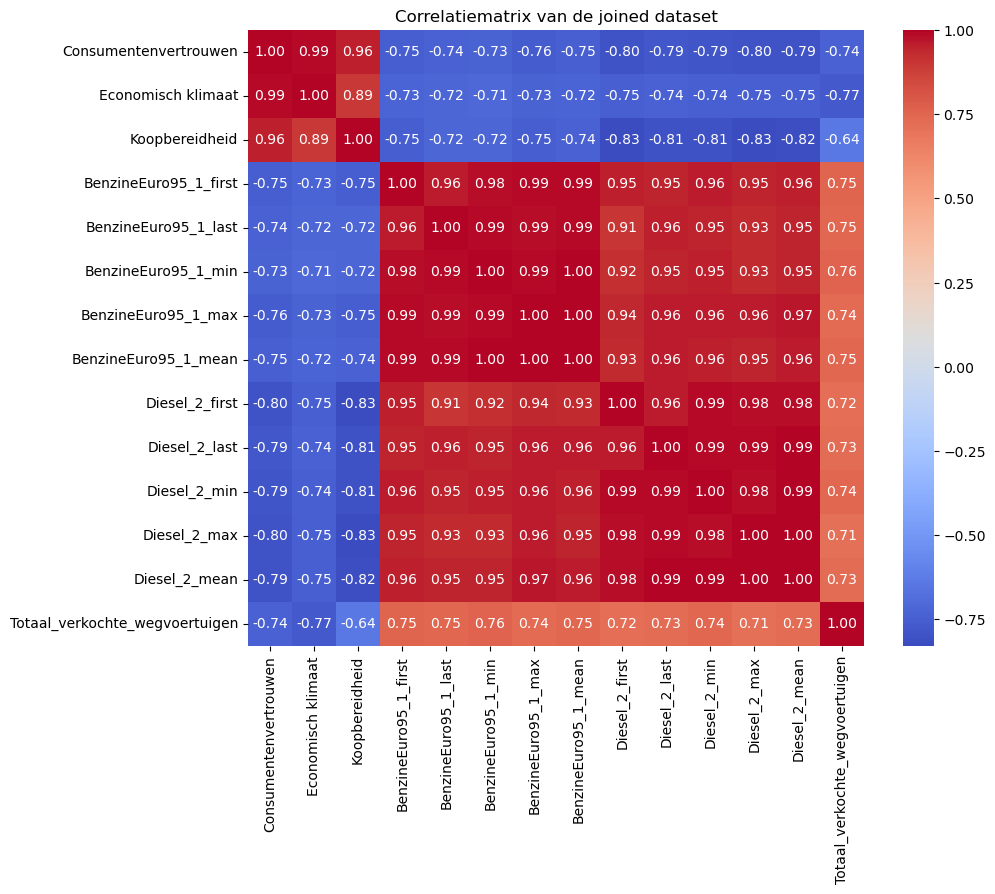

In [3]:
# Correlatiematrix berekenen
correlation_matrix = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets.csv")
correlation_matrix = correlation_matrix.corr(numeric_only=True)

# Heatmap plotten
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlatiematrix van de joined dataset")
plt.show()


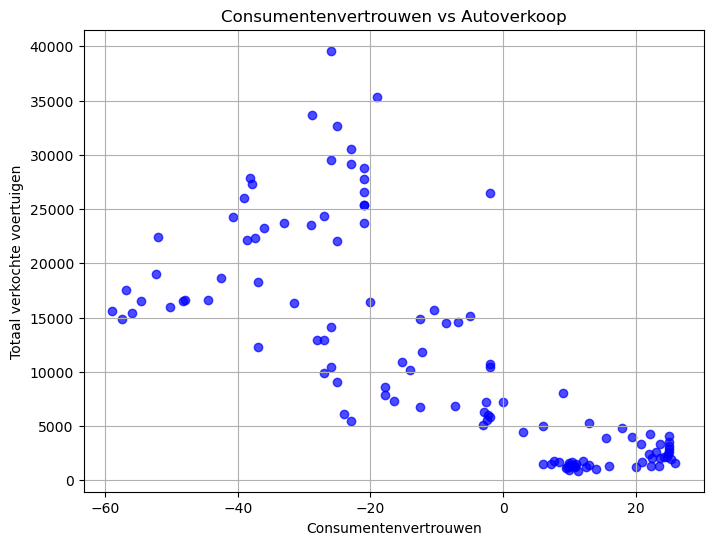

In [29]:
# Scatterplot: Consumentenvertrouwen vs Autoverkoop
plt.figure(figsize=(8, 6))
plt.scatter(df_joined['Consumentenvertrouwen'], df_joined['Totaal_verkochte_wegvoertuigen'], alpha=0.7, color='blue')
plt.title('Consumentenvertrouwen vs Autoverkoop')
plt.xlabel('Consumentenvertrouwen')
plt.ylabel('Totaal verkochte voertuigen')
plt.grid(True)
plt.show()

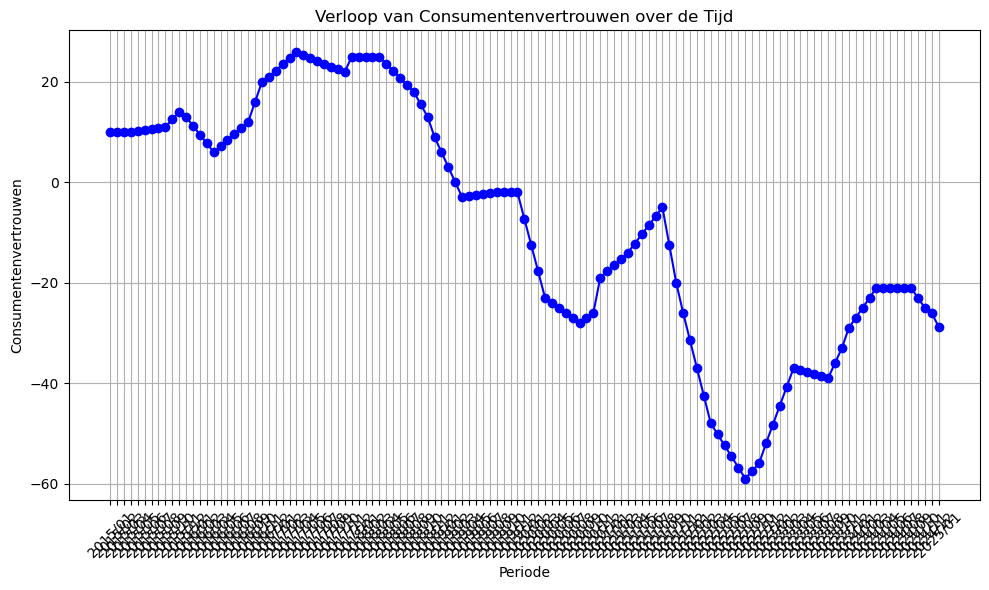

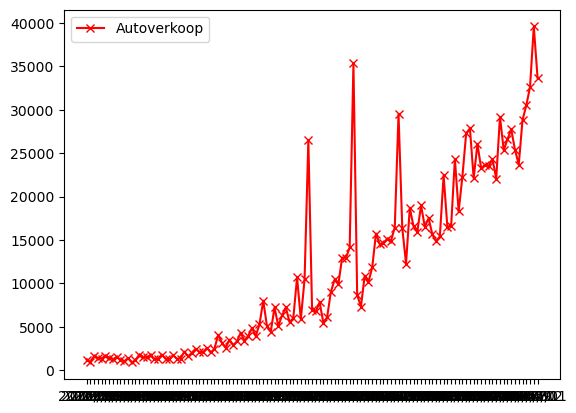

In [31]:
# Plot: Verloop van Consumentenvertrouwen over de tijd
plt.figure(figsize=(10, 6))
plt.plot(df_joined['Periode'], df_joined['Consumentenvertrouwen'], marker='o', color='blue')
plt.title('Verloop van Consumentenvertrouwen over de Tijd')
plt.xlabel('Periode')
plt.ylabel('Consumentenvertrouwen')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Verloop van Autoverkoop over de tijd
plt.plot(df_joined['Periode'], df_joined['Totaal_verkochte_wegvoertuigen'], marker='x', color='red', label='Autoverkoop')

# Voeg een legenda toe
plt.legend()

Heeft consumenten vertrouwen zich ontwikkeld

De correlatiematrix laat zien dat:

Benzine- en dieselprijzen een sterke positieve correlatie (rond 0.73-0.75) hebben met het aantal verkochte elektrische voertuigen.

Consumentenvertrouwen en economisch klimaat hebben een negatieve correlatie (rond -0.74 tot -0.77) met autoverkopen.

Dit suggereert dat stijgende brandstofprijzen samengaan met meer elektrische autoverkopen, terwijl een dalend consumentenvertrouwen mogelijk leidt tot hogere verkopen, mogelijk door stimuleringsmaatregelen.

Daarnaast kan het toepassen van een lagfactor op variabelen zoals brandstofprijzen en consumentenvertrouwen waardevol zijn. Veranderingen in deze indicatoren hebben waarschijnlijk een vertraagd effect op autoverkopen, bijvoorbeeld enkele maanden later. Het gebruik van lag-variabelen helpt om dit effect te modelleren en de voorspellende kracht van het model te verbeteren.


In [4]:




df_joined = pd.read_csv(r"E:\Nieuw dataset\df_joined_datasets.csv")

# 1. Alleen relevante features pakken (zonder 'Periode')
features = df_joined.drop(columns=['Periode']).values

# 2. Sliding window toepassen (6 lags)
n_lags = 6

# Define the series_to_supervised function
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j+1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

supervised = series_to_supervised(features, n_in=n_lags)

# 3. Omzetten naar NumPy array
supervised_values = supervised.values

# 4. Train/test split (laatste 12 maanden als test)
n_test = 12
train, test = supervised_values[:-n_test], supervised_values[-n_test:]

from xgboost import XGBRegressor
import numpy as np

# XGBoost forecast functie
def xgboost_forecast(train, testX):
    trainX, trainy = train[:, :-1], train[:, -1]  # splits input/output
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)
    yhat = model.predict(np.array([testX]))
    return yhat[0]


# 5. Walk-forward validation uitvoeren
predictions = []
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = xgboost_forecast(np.array(history), testX)
    predictions.append(yhat)
    history.append(test[i])

# 6. MAE berekenen
actual = test[:, -1]
mae = mean_absolute_error(actual, predictions)

mae, actual, predictions


# 7. Foutmarge per maand (percentage)
fouten = np.abs(actual - predictions)
foutmarges = (fouten / actual) * 100  # procentuele fout

# Print resultaten overzichtelijk
for i in range(len(actual)):
    print(f"Maand {i+1}: Werkelijk={actual[i]}, Voorspeld={predictions[i]:.1f}, Fout={fouten[i]:.1f}, Foutmarge={foutmarges[i]:.2f}%")

# Totale MAE
print(f"\nMAE: {mae:.2f}")


Maand 1: Werkelijk=22060.0, Voorspeld=24068.6, Fout=2008.6, Foutmarge=9.10%
Maand 2: Werkelijk=29193.0, Voorspeld=21791.1, Fout=7401.9, Foutmarge=25.36%
Maand 3: Werkelijk=25326.0, Voorspeld=27414.6, Fout=2088.6, Foutmarge=8.25%
Maand 4: Werkelijk=26607.0, Voorspeld=23810.2, Fout=2796.8, Foutmarge=10.51%
Maand 5: Werkelijk=27731.0, Voorspeld=24069.4, Fout=3661.6, Foutmarge=13.20%
Maand 6: Werkelijk=25370.0, Voorspeld=23942.2, Fout=1427.8, Foutmarge=5.63%
Maand 7: Werkelijk=23683.0, Voorspeld=26062.0, Fout=2379.0, Foutmarge=10.05%
Maand 8: Werkelijk=28820.0, Voorspeld=23167.1, Fout=5652.9, Foutmarge=19.61%
Maand 9: Werkelijk=30491.0, Voorspeld=26553.2, Fout=3937.8, Foutmarge=12.91%
Maand 10: Werkelijk=32623.0, Voorspeld=28185.0, Fout=4438.0, Foutmarge=13.60%
Maand 11: Werkelijk=39594.0, Voorspeld=29159.3, Fout=10434.7, Foutmarge=26.35%
Maand 12: Werkelijk=33680.0, Voorspeld=35184.1, Fout=1504.1, Foutmarge=4.47%

MAE: 3977.64


> MAE (±3977) geeft een redelijk idee van de gemiddelde afwijking. Gezien het verkoopvolume (tussen 20.000 - 40.000) is dat een afwijking van ongeveer 10-15%

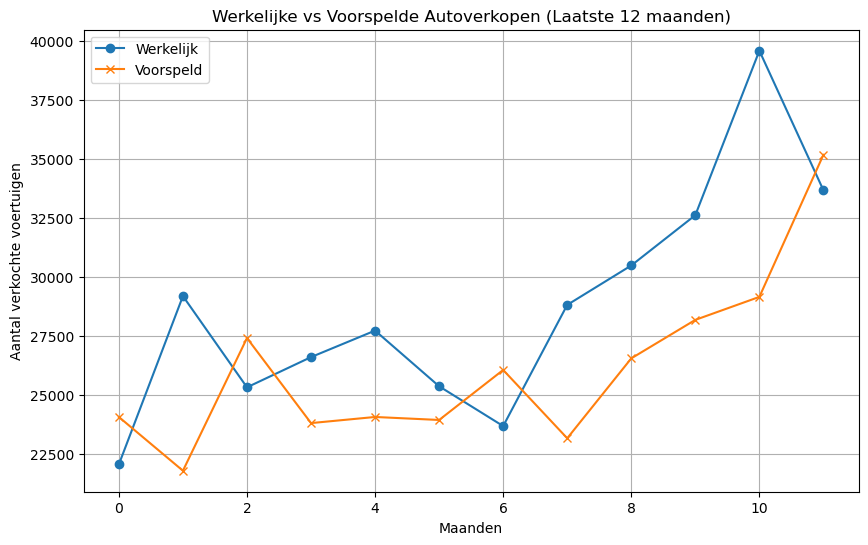

In [6]:
# Plot: Werkelijk vs Voorspeld
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Werkelijk', marker='o')
plt.plot(predictions, label='Voorspeld', marker='x')
plt.title('Werkelijke vs Voorspelde Autoverkopen (Laatste 12 maanden)')
plt.xlabel('Maanden')
plt.ylabel('Aantal verkochte voertuigen')
plt.legend()
plt.grid(True)
plt.show()


> laat mooi zien dat de voorspellingen de trend globaal volgen, al misy hij  soms de pieken/dalen (vooral bij hogere verkoopaantallen). Lijkt mij ook goed om onderzoek uit te voeren wat voor nieuws gebeurt bij de pieken/dalen 

### Feature importance using Leave One Feature Out (LOFO) Importance
en train-val-test split
n_total = len(supervised_values)
    n_test = 12  # laatste 12 maanden
    n_val = 10   # 10 maanden daarvoor
    n_train = n_total - n_val - n_test

https://elicit.com/review/34f86fac-9b35-4237-9b80-24816323e242

#### Voorbereiding – kolommen groeperen voor LOFO

In [ ]:
# Groepeer je features in betekenisvolle groepen voor LOFO
feature_groups = {
    #'Nieuws': [col for col in df_joined.columns if 'sentiment' in col.lower()], # heb nog geen nieuwsentimennt
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Voorgaande_verkoop': ['Totaal_verkochte_wegvoertuigen'],
}


#### LOFO loop

In [ ]:
results = []

for group_name, excluded_cols in feature_groups.items():
    print(f"\n LOFO - Zonder: {group_name}")

    # Dataset zonder de huidige featuregroep
    df_lofo = df_joined.drop(columns=excluded_cols + ['Periode'])

    #  Print welke features wel worden gebruikt
    included_cols = df_lofo.columns.tolist()
    print(f" Gebruikte features ({len(included_cols)}): {included_cols}")

    # Series to supervised
    features = df_lofo.values
    supervised = series_to_supervised(features, n_in=6)
    supervised_values = supervised.values

    # Splitsen in train/val/test
    n_total = len(supervised_values)
    n_test = 12  # Laatste 12 maanden als testset
    n_val = 10   # 10 maanden daarvoor als validatieset
    n_train = n_total - n_val - n_test  # Rest als trainingset

    # Train/val/test sets
    train = supervised_values[:n_train]
    val = supervised_values[n_train:n_train + n_val]
    test = supervised_values[n_train + n_val:]


    # Train XGBoost op train+val
    full_train = np.concatenate([train, val])  # Combineer train en val voor betere generalisatie
    trainX, trainy = full_train[:, :-1], full_train[:, -1]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)

    # Test
    testX, testy = test[:, :-1], test[:, -1]
    predictions = model.predict(testX)

    # MAE + foutmarge
    mae = mean_absolute_error(testy, predictions)
    fouten = np.abs(testy - predictions)
    foutmarges = (fouten / testy) * 100
    avg_foutmarge = foutmarges.mean()

    print(f" MAE: {mae:.2f}, Gemiddelde foutmarge: {avg_foutmarge:.2f}%")

    # Resultaat opslaan
    results.append({
        'weggelaten_featuregroep': group_name,
        'aantal_features_gebruikt': len(included_cols),
        'mae': mae,
        'gem_foutmarge_%': avg_foutmarge
    })



 LOFO - Zonder: Brandstofprijzen
 Gebruikte features (4): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Totaal_verkochte_wegvoertuigen']
 MAE: 10041.54, Gemiddelde foutmarge: 32.67%

 LOFO - Zonder: Economisch
 Gebruikte features (11): ['BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen']
 MAE: 7297.38, Gemiddelde foutmarge: 23.04%

 LOFO - Zonder: Voorgaande_verkoop
 Gebruikte features (13): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean']
 MAE: 0.03, Gemiddelde foutmarge: 1.92%


####  Resultaten 

,weggelaten_featuregroep,aantal_features_gebruikt,mae,gem_foutmarge_%
2,Voorgaande_verkoop,13,0.033349,1.923462
1,Economisch,11,7297.380697,23.037934
0,Brandstofprijzen,4,10041.535319,32.665651


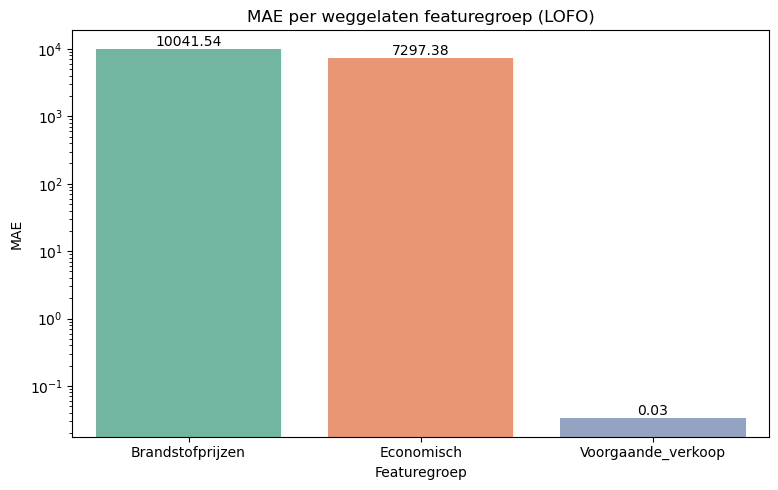

In [17]:

# DataFrame van resultaten
df_results = pd.DataFrame(results)
display(df_results.sort_values(by='mae'))

# Barplot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=df_results, x='weggelaten_featuregroep', y='mae', hue='weggelaten_featuregroep', dodge=False, palette='Set2', legend=False)
plt.title("MAE per weggelaten featuregroep (LOFO)")
plt.ylabel("MAE")
plt.xlabel("Featuregroep")
plt.tight_layout()
plt.yscale("log")

# Add MAE values on top of the bars
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=10)

plt.show()


#### Combinatie tussen lagtime en LOFO

In [19]:
# Featuregroepen (zonder sentiment)
feature_groups = {
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Voorgaande_verkoop': ['Totaal_verkochte_wegvoertuigen'],
}

# Verschillende lagcombinaties
lag_sets = [
    [1, 3, 6],
    [1, 6, 12],
    [3, 6, 12],
    [1, 3, 6, 12],
]

In [ ]:
# Custom lag functie
def series_to_supervised_custom_lags(data, lags):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for lag in lags:
        cols.append(df.shift(lag))
        names += [f'var{j+1}(t-{lag})' for j in range(n_vars)]

    cols.append(df)  # target op t
    names += [f'var{j+1}(t)' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

# Resultaten opslaan
results = []

for lags in lag_sets:
    for group_name, excluded_cols in feature_groups.items():
        print(f"\n Lagconfig: {lags} | Zonder groep: {group_name}")

        df_lofo = df_joined.drop(columns=excluded_cols + ['Periode'])
        included_cols = df_lofo.columns.tolist()
        print(f" Gebruikte features ({len(included_cols)}): {included_cols}")

        features = df_lofo.values
        supervised = series_to_supervised_custom_lags(features, lags)
        supervised_values = supervised.values

        # Splits
        n_total = len(supervised_values)
        n_test = 12
        n_val = 10
        n_train = n_total - n_val - n_test

        train = supervised_values[:n_train]
        val = supervised_values[n_train:n_train + n_val]
        test = supervised_values[n_train + n_val:]

        # Train op train + val
        full_train = np.concatenate([train, val])
        trainX, trainy = full_train[:, :-1], full_train[:, -1]

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(trainX, trainy)

        testX, testy = test[:, :-1], test[:, -1]
        predictions = model.predict(testX)

        mae = mean_absolute_error(testy, predictions)
        fouten = np.abs(testy - predictions)
        foutmarges = (fouten / testy) * 100
        avg_foutmarge = foutmarges.mean()

        print(f" MAE: {mae:.2f}, Foutmarge: {avg_foutmarge:.2f}%")

        results.append({
            'lags': str(lags),
            'weggelaten_featuregroep': group_name,
            'aantal_features_gebruikt': len(included_cols),
            'mae': mae,
            'gem_foutmarge_%': avg_foutmarge
        })


🧪 Lagconfig: [1, 3, 6] | Zonder groep: Brandstofprijzen
📌 Gebruikte features (4): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Totaal_verkochte_wegvoertuigen']
📊 MAE: 7234.06, Foutmarge: 22.92%

🧪 Lagconfig: [1, 3, 6] | Zonder groep: Economisch
📌 Gebruikte features (11): ['BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean', 'Totaal_verkochte_wegvoertuigen']
📊 MAE: 6932.15, Foutmarge: 21.60%

🧪 Lagconfig: [1, 3, 6] | Zonder groep: Voorgaande_verkoop
📌 Gebruikte features (13): ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min', 'BenzineEuro95_1_max', 'BenzineEuro95_1_mean', 'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean']
📊 MAE: 0.03, Foutmarge: 1.89%

🧪 Lagconfig: [1, 6, 12] | Zonder groep: Brandst

In [21]:
# Resultaten tonen
df_results_lofo_lags = pd.DataFrame(results)
df_results_lofo_lags.head()

,lags,weggelaten_featuregroep,aantal_features_gebruikt,mae,gem_foutmarge_%
0,"[1, 3, 6]",Brandstofprijzen,4,7234.058187,22.919290
1,"[1, 3, 6]",Economisch,11,6932.145671,21.595132
2,"[1, 3, 6]",Voorgaande_verkoop,13,0.032774,1.891512
3,"[1, 6, 12]",Brandstofprijzen,4,6045.958822,19.581326
4,"[1, 6, 12]",Economisch,11,6101.581380,19.553035


In [ ]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np
from IPython.display import display

# Range van individuele lags (1 t/m 24 maanden terug)
single_lags = list(range(1, 25))

# Resultaten opslaan
results_lolo = []

# Zelfde featureset gebruiken
df_base = df_joined.drop(columns=['Periode'])
features = df_base.values

# Loop over elke individuele lag
for lag in single_lags:
    print(f"\n🔁 Evaluatie met alleen lag t-{lag}")

    # Maak supervised data met alleen deze lag
    supervised = series_to_supervised_custom_lags(features, [lag])
    supervised_values = supervised.values

    # Splitsen
    n_total = len(supervised_values)
    n_test = 12
    n_val = 10
    n_train = n_total - n_val - n_test

    train = supervised_values[:n_train]
    val = supervised_values[n_train:n_train + n_val]
    test = supervised_values[n_train + n_val:]

    # Train op train + val
    full_train = np.concatenate([train, val])
    trainX, trainy = full_train[:, :-1], full_train[:, -1]

    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(trainX, trainy)

    # Test
    testX, testy = test[:, :-1], test[:, -1]
    predictions = model.predict(testX)

    # MAE + foutmarge
    mae = mean_absolute_error(testy, predictions)
    fouten = np.abs(testy - predictions)
    foutmarges = (fouten / testy) * 100
    avg_foutmarge = foutmarges.mean()

    print(f"📊 MAE: {mae:.2f}, Foutmarge: {avg_foutmarge:.2f}%")

    results_lolo.append({
        'lag_maand': f"t-{lag}",
        'mae': mae,
        'gem_foutmarge_%': avg_foutmarge
    })

# Omzetten naar DataFrame
df_results_lolo = pd.DataFrame(results_lolo)
# Display the results DataFrame




🔁 Evaluatie met alleen lag t-1
📊 MAE: 6545.88, Foutmarge: 20.06%

🔁 Evaluatie met alleen lag t-2
📊 MAE: 11562.37, Foutmarge: 37.95%

🔁 Evaluatie met alleen lag t-3
📊 MAE: 7286.93, Foutmarge: 24.22%

🔁 Evaluatie met alleen lag t-4
📊 MAE: 11027.18, Foutmarge: 36.94%

🔁 Evaluatie met alleen lag t-5
📊 MAE: 6320.26, Foutmarge: 20.58%

🔁 Evaluatie met alleen lag t-6
📊 MAE: 7084.49, Foutmarge: 22.47%

🔁 Evaluatie met alleen lag t-7
📊 MAE: 6845.03, Foutmarge: 21.35%

🔁 Evaluatie met alleen lag t-8
📊 MAE: 9126.19, Foutmarge: 30.86%

🔁 Evaluatie met alleen lag t-9
📊 MAE: 6777.56, Foutmarge: 21.68%

🔁 Evaluatie met alleen lag t-10
📊 MAE: 5628.90, Foutmarge: 17.72%

🔁 Evaluatie met alleen lag t-11
📊 MAE: 6431.59, Foutmarge: 20.97%

🔁 Evaluatie met alleen lag t-12
📊 MAE: 4553.89, Foutmarge: 14.09%

🔁 Evaluatie met alleen lag t-13
📊 MAE: 6738.99, Foutmarge: 22.37%

🔁 Evaluatie met alleen lag t-14
📊 MAE: 6732.90, Foutmarge: 21.75%

🔁 Evaluatie met alleen lag t-15
📊 MAE: 4621.87, Foutmarge: 14.71%

🔁

,lag_maand,mae,gem_foutmarge_%
0,t-1,6545.876139,20.057617
1,t-2,11562.373698,37.951256
2,t-3,7286.934733,24.215121
3,t-4,11027.181396,36.936362
4,t-5,6320.263021,20.578687
5,t-6,7084.486165,22.470339
6,t-7,6845.031087,21.348530
7,t-8,9126.191243,30.861955
8,t-9,6777.559733,21.678002
9,t-10,5628.901204,17.720073


In [28]:

# Display the LOLO results DataFrame
display(df_results_lolo)

,lag_maand,mae,gem_foutmarge_%
0,t-1,6545.876139,20.057617
1,t-2,11562.373698,37.951256
2,t-3,7286.934733,24.215121
3,t-4,11027.181396,36.936362
4,t-5,6320.263021,20.578687
5,t-6,7084.486165,22.470339
6,t-7,6845.031087,21.348530
7,t-8,9126.191243,30.861955
8,t-9,6777.559733,21.678002
9,t-10,5628.901204,17.720073


In [27]:
from IPython.display import display

# LOFO × LOLO gecombineerd: 1 lag tegelijk, 1 featuregroep weggelaten

combined_results = []

# Definieer je featuregroepen
feature_groups = {
    'Brandstofprijzen': [col for col in df_joined.columns if 'benzine' in col.lower() or 'diesel' in col.lower()],
    'Economisch': ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid'],
    'Voorgaande_verkoop': ['Totaal_verkochte_wegvoertuigen'],
}

# Dataset zonder 'Periode'
df_base = df_joined.drop(columns=['Periode'])

# Featurematrix
features_full = df_base.values
lags = list(range(1, 25))

for group_name, excluded_cols in feature_groups.items():
    print(f"\n📂 LOFO-groep: {group_name}")

    df_lofo = df_base.drop(columns=excluded_cols)
    features = df_lofo.values
    included_cols = df_lofo.columns.tolist()

    for lag in lags:
        print(f"   ➤ Lag t-{lag}")

        # Supervised voor huidige lag
        supervised = series_to_supervised_custom_lags(features, [lag])
        supervised_values = supervised.values

        # Train/val/test splits
        n_total = len(supervised_values)
        n_test = 12
        n_val = 10
        n_train = n_total - n_val - n_test

        train = supervised_values[:n_train]
        val = supervised_values[n_train:n_train + n_val]
        test = supervised_values[n_train + n_val:]

        # Combineer train en val
        full_train = np.concatenate([train, val])
        trainX, trainy = full_train[:, :-1], full_train[:, -1]

        model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(trainX, trainy)

        # Test
        testX, testy = test[:, :-1], test[:, -1]
        predictions = model.predict(testX)

        # Evaluatie
        mae = mean_absolute_error(testy, predictions)
        fouten = np.abs(testy - predictions)
        foutmarges = (fouten / testy) * 100
        avg_foutmarge = foutmarges.mean()

        combined_results.append({
            'featuregroep': group_name,
            'lag': f"t-{lag}",
            'aantal_features': len(included_cols),
            'mae': mae,
            'foutmarge_%': avg_foutmarge
        })
        # Omzetten naar DataFrame        #
# Omzetten naar DataFrame
df_combined_lofo_lolo = pd.DataFrame(combined_results)
# Display the combined LOFO × LOLO results DataFrame

# Display the results DataFrame
display(df_combined_lofo_lolo)



📂 LOFO-groep: Brandstofprijzen
   ➤ Lag t-1
   ➤ Lag t-2
   ➤ Lag t-3
   ➤ Lag t-4
   ➤ Lag t-5
   ➤ Lag t-6
   ➤ Lag t-7
   ➤ Lag t-8
   ➤ Lag t-9
   ➤ Lag t-10
   ➤ Lag t-11
   ➤ Lag t-12
   ➤ Lag t-13
   ➤ Lag t-14
   ➤ Lag t-15
   ➤ Lag t-16
   ➤ Lag t-17
   ➤ Lag t-18
   ➤ Lag t-19
   ➤ Lag t-20
   ➤ Lag t-21
   ➤ Lag t-22
   ➤ Lag t-23
   ➤ Lag t-24

📂 LOFO-groep: Economisch
   ➤ Lag t-1
   ➤ Lag t-2
   ➤ Lag t-3
   ➤ Lag t-4
   ➤ Lag t-5
   ➤ Lag t-6
   ➤ Lag t-7
   ➤ Lag t-8
   ➤ Lag t-9
   ➤ Lag t-10
   ➤ Lag t-11
   ➤ Lag t-12
   ➤ Lag t-13
   ➤ Lag t-14
   ➤ Lag t-15
   ➤ Lag t-16
   ➤ Lag t-17
   ➤ Lag t-18
   ➤ Lag t-19
   ➤ Lag t-20
   ➤ Lag t-21
   ➤ Lag t-22
   ➤ Lag t-23
   ➤ Lag t-24

📂 LOFO-groep: Voorgaande_verkoop
   ➤ Lag t-1
   ➤ Lag t-2
   ➤ Lag t-3
   ➤ Lag t-4
   ➤ Lag t-5
   ➤ Lag t-6
   ➤ Lag t-7
   ➤ Lag t-8
   ➤ Lag t-9
   ➤ Lag t-10
   ➤ Lag t-11
   ➤ Lag t-12
   ➤ Lag t-13
   ➤ Lag t-14
   ➤ Lag t-15
   ➤ Lag t-16
   ➤ Lag t-17
   ➤ Lag t-18
   ➤ Lag t-

,featuregroep,lag,aantal_features,mae,foutmarge_%
0,Brandstofprijzen,t-1,4,6694.416504,20.955935
1,Brandstofprijzen,t-2,4,17875.368164,61.121183
2,Brandstofprijzen,t-3,4,6840.406087,22.194614
3,Brandstofprijzen,t-4,4,14254.250651,48.186436
4,Brandstofprijzen,t-5,4,10330.729899,33.765850
...,...,...,...,...,...
67,Voorgaande_verkoop,t-20,13,0.031431,1.809362
68,Voorgaande_verkoop,t-21,13,0.037256,2.138094
69,Voorgaande_verkoop,t-22,13,0.036975,2.121946
70,Voorgaande_verkoop,t-23,13,0.036510,2.090613
